<a href="https://colab.research.google.com/github/VihaShahh/Music-Recommendation/blob/main/music_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import warnings
warnings.filterwarnings("ignore")

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta
from sklearn.impute import SimpleImputer
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FormatStrFormatter

from lightgbm import LGBMClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, roc_curve

import sklearn.datasets
import sklearn.metrics
import optuna

In [8]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
3  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
4  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   
3  2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=        my library   
4  3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=           explore   

    source_screen_name      source_type  target  
0              Explore  online-playlist     1.0  
1  Local playlist more   local-playlist     1.0  
2  Local playlist more   local-playlist     1.0  
3  Local playlist more   local-playlist     1.0  
4              Explore  online-playlist     1.0

In [9]:
df_train.shape

(31173, 6)

In [10]:
df_songs = pd.read_csv('/content/songs.csv')
df_songs.head()

song_id  song_length genre_ids  \
0  CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640       465   
1  o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=       197328       444   
2  DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=       231781       465   
3  dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=       273554       465   
4  W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=       140329       726   

        artist_name                            composer     lyricist  language  
0  張信哲 (Jeff Chang)                                  董貞          何啟弘       3.0  
1         BLACKPINK  TEDDY|  FUTURE BOUNCE|  Bekuh BOOM        TEDDY      31.0  
2      SUPER JUNIOR                                 NaN          NaN      31.0  
3             S.H.E                                 湯小康          徐世珍       3.0  
4              貴族精選                         Traditional  Traditional      52.0

In [11]:
df_songs.shape

(42270, 7)

In [12]:
# Merge datasets by the song_id column

df_full = pd.merge(left=df_train, right=df_songs, on='song_id', how='left')
df_full.head(3)

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist     1.0          NaN       NaN   
1  Local playlist more   local-playlist     1.0          NaN       NaN   
2  Local playlist more   local-playlist     1.0          NaN       NaN   

  artist_name composer lyricist  language  
0         NaN      NaN      NaN       NaN  
1         NaN      NaN      NaN       NaN  
2         NaN      NaN      NaN       NaN

In [13]:
df_full.shape

(31173, 12)

In [14]:
df_songs_extra = pd.read_csv('/content/song_extra_info.csv')
df_songs_extra.head()

song_id             name          isrc
0  LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=               我們  TWUM71200043
1  ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=  Let Me Love You  QMZSY1600015
2  u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=              原諒我  TWA530887303
3  92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=          Classic  USSM11301446
4  0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=             愛投羅網  TWA471306001

In [15]:
df_full = pd.merge(left=df_full, right=df_songs_extra, on='song_id', how='left')
df_full.head(3)

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist     1.0          NaN       NaN   
1  Local playlist more   local-playlist     1.0          NaN       NaN   
2  Local playlist more   local-playlist     1.0          NaN       NaN   

  artist_name composer lyricist  language name isrc  
0         NaN      NaN      NaN       NaN  NaN  NaN  
1         NaN      NaN      NaN       NaN  NaN  NaN  
2         NaN      NaN      NaN       NaN  NaN  NaN

In [16]:
df_full.shape

(31173, 14)

In [17]:
df_members = pd.read_csv('/content/members.csv')
df_members.head()

msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1   0    NaN   
1  UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=     1   0    NaN   
2  D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=     1   0    NaN   
3  mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=     1   0    NaN   
4  q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=     1   0    NaN   

   registered_via  registration_init_time  expiration_date  
0               7                20110820         20170920  
1               7                20150628         20170622  
2               4                20160411         20170712  
3               9                20150906         20150907  
4               4                20170126         20170613

In [18]:
# Also check the dataset size

df_members.shape

(34403, 7)

In [19]:
df_full = pd.merge(left=df_full, right=df_members, on='msno', how='left')
df_full.head(3)

msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   
1  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   
2  Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   
1  bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=        my library   
2  JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=        my library   

    source_screen_name      source_type  target  song_length genre_ids  \
0              Explore  online-playlist     1.0          NaN       NaN   
1  Local playlist more   local-playlist     1.0          NaN       NaN   
2  Local playlist more   local-playlist     1.0          NaN       NaN   

  artist_name composer lyricist  language name isrc  city  bd  gender  \
0         NaN      NaN      NaN       NaN  NaN  NaN     1   0     NaN   
1         NaN      NaN      NaN       NaN  NaN  NaN    13  24  female   
2         NaN      NaN      NaN       NaN  NaN  NaN    13  24  female   

   registered_via  registration_init_time  expiration_date  
0               7                20120102         20171005  
1               9                20110525         20170911  
2               9                20110525         20170911

In [20]:
# Check the finally dataset size

df_full.shape

(31173, 20)

In [21]:
# Use one of the AutoEDA tool - Pandas Profile Report from pandas_profiling libruary
# Function report output

profile = ProfileReport(df_full, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
# Determining the number of completely filled objects, the percentage and the number of missing values in features:
# We will need this several times for EDA, so I will create two functions for this purpose

def print_useful_rows_info(df):
    print('Number of completely filled objects from the entire sample:', len(df.dropna()))
    print('Percent of completely filled objects from the entire sample:', round(len(df.dropna()) / len(df) * 100, 2))

def missing_values(df):
    n = 0
    missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
    for i in range(0, len(missing_values)):
        if missing_values[i] > 0:
            print(missing_values.index[i], '-', df.loc[:, missing_values.index[i]].isna().sum())
            n += 1
        if n == 0 and i == len(missing_values) - 1:
            print(n)

print_useful_rows_info(df_full)
perc_missing_values = ((df_full.isna().sum() / len(df_full)) * 100).sort_values(ascending=False)
print(f'Percent of missing values:\n' + f'{perc_missing_values}')

Number of completely filled objects from the entire sample: 321
Percent of completely filled objects from the entire sample: 1.03
Percent of missing values:
lyricist                  90.514227
isrc                      89.869438
name                      88.833285
composer                  87.902993
genre_ids                 84.913226
song_length               84.630931
artist_name               84.630931
language                  84.630931
gender                    39.216630
source_screen_name         3.297726
source_system_tab          0.295127
source_type                0.208514
target                     0.003208
registration_init_time     0.000000
registered_via             0.000000
msno                       0.000000
bd                         0.000000
city                       0.000000
song_id                    0.000000
expiration_date            0.000000
dtype: float64


In [23]:
print('Number of missing values in columns:')
missing_values(df_full)

Number of missing values in columns:
lyricist - 28216
isrc - 28015
name - 27692
composer - 27402
genre_ids - 26470
song_length - 26382
artist_name - 26382
language - 26382
gender - 12225
source_screen_name - 1028
source_system_tab - 92
source_type - 65
target - 1


In [24]:
# Leave only filled rows for features with gaps less than 1%

df_full = df_full[(df_full.artist_name.notna()) & (df_full.source_system_tab.notna()) & (df_full.source_type.notna()) &
                 (df_full.name.notna()) & (df_full.language.notna())]

In [25]:
# Check the number of missing values in columns

print('Number of missing values in columns:')
missing_values(df_full)

Number of missing values in columns:
gender - 359
lyricist - 353
composer - 245
isrc - 112
source_screen_name - 31
genre_ids - 17


In [26]:
# Convert the data type of some numeric features to 'str', since they are actually categorical. For the model, for example,
# 20 > 15, but in fact it cannot be said that one city is better than another by 25%. This can degrade the predictive ability
# of the model.

df_full.genre_ids = df_full.genre_ids.astype('str')
df_full.registered_via = df_full.registered_via.astype('str')
df_full.city = df_full.city.astype('str')
df_full.language = df_full.language.astype('str')

In [27]:
# Create a function to calculate the interquartile range

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

Bottom border -  -45.0 
Upper border -  75.0 
Number of outliers -  0


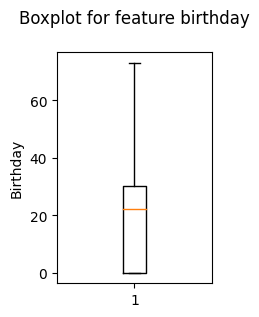

In [28]:
# Define outliers with a function in feature 'birthday'(or 'bd') and vizualizate it

boundaries = calculate_outliers(df_full['bd'])
outlier = (df_full['bd'] < boundaries[0]) | (df_full['bd'] > boundaries[1])
print('Bottom border - ', boundaries[0], '\nUpper border - ', boundaries[1], '\nNumber of outliers - ', outlier.sum())

plt.figure(figsize=(2, 3))
plt.boxplot(df_full['bd'][df_full['bd'].notna()], sym='.')
plt.ylabel('Birthday')
plt.title('Boxplot for feature birthday' + '\n')
plt.show();

In [29]:
# The values 150, 900, 1000 years are clearly outliers. Removing them from the dataset

df_full = df_full[df_full.bd < boundaries[1]]

In [30]:
# Create a function to plot the distribution of feature values

def distribution_graph(data, feat, n_bins):
    fig, ax = plt.subplots(figsize=(5, 3))

    ax.hist(data.values, bins=n_bins, color=['blue'])
    ax.set_xlabel('Feature value ' + feat)
    ax.set_ylabel('Frequency')
    ax.set_title('Feature distribution ' + feat)
    fig.autofmt_xdate(rotation=45)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'));

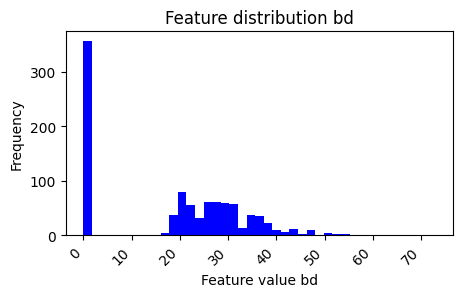

In [31]:
# Displaying a distribution plot for feature 'bd'

distribution_graph(df_full.bd, 'bd', df_full['bd'].nunique())

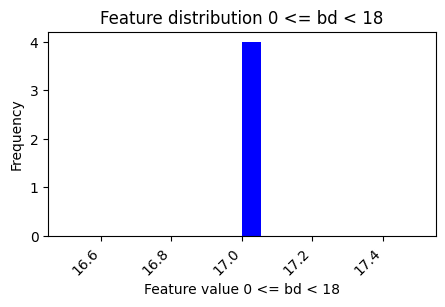

In [32]:
#  ... and separately for age before 18

distribution_graph(df_full.bd[(df_full.bd < 18) & df_full.bd[(df_full.bd >= 0)]], '0 <= bd < 18', 18)

In [33]:
# It is unlikely that children 4, 6 or 8 years old could create and use an account. In any case, there are not many such values.
# Also remove them from the dataset

df_full = df_full[df_full.bd >= 15]

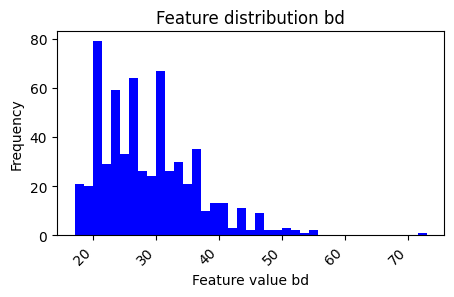

In [34]:
distribution_graph(df_full.bd, 'bd', df_full['bd'].nunique())

In [35]:
# Convert the registration_init_time and expiration date attributes to datetime and generate new attributes: day of the month,
# day of the week, month, year of registration start and end, and its duration in days

df_full.registration_init_time = df_full.registration_init_time.astype('str')
df_full.registration_init_time = df_full.registration_init_time.apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
df_full.registration_init_time = pd.to_datetime(df_full.registration_init_time)
df_full['r_month'] = df_full.registration_init_time.dt.month
df_full['r_dayofweek'] = df_full.registration_init_time.dt.weekday
df_full['r_year'] = df_full.registration_init_time.dt.year
df_full['r_day'] = df_full.registration_init_time.dt.day

df_full.expiration_date = df_full.expiration_date.astype('str')
df_full.expiration_date = df_full.expiration_date.apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:8])
df_full.expiration_date = pd.to_datetime(df_full.expiration_date)
df_full['e_month'] = df_full.expiration_date.dt.month
df_full['e_dayofweek'] = df_full.expiration_date.dt.weekday
df_full['e_year'] = df_full.expiration_date.dt.year
df_full['e_day'] = df_full.expiration_date.dt.day

df_full['re_delta'] = df_full.apply(lambda x: (x.expiration_date - x.registration_init_time).days, axis=1)

df_full = df_full.drop(columns=['expiration_date', 'registration_init_time'])
df_full.head()

msno  \
95   Eaq21N7ijazDjnqU5v1jjWewJopGxgZxkKr4GIq7JTs=   
169  LGIeu7rj6KryPWev2nr5g807ZPtw4b59wqDn5jighcw=   
222  iVDh2yjFOMgO7Ew2vuDv9n8g+uVX8wW5wkuSdeqCf8Q=   
312  rr4UgAoJj0ry3aAo7SJy6RZy8psI9aPwgIQiA1cu39Q=   
355  wRKpx+fzd5Eb0c73MIooZzvPpdOyOnMg1hAKh5dohaw=   

                                          song_id source_system_tab  \
95   BwDDym6Tp7EnGudWBGJyjONZeX0/4ndu5PETiPWzav8=        my library   
169  0ee/D6HjX0jSytUn3v58C0x6zEzN4bcPq3WlqvrG/Xo=          discover   
222  nFahnwpZ1xS1sO7g3LSOcqZGX8KSgZcEBY4X60mzUN4=        my library   
312  IEBOvGhtj0uhqcdmH41YJVUlTMyRNDpZ/jTaFR0NkWE=        my library   
355  +2r/RLKIXV7fDGROmzAKu9NOiH0zsbe6eAwrhijRFBc=        my library   

       source_screen_name          source_type  target  song_length genre_ids  \
95                    NaN        local-library     1.0     333024.0       458   
169  Online playlist more  song-based-playlist     1.0     195944.0       359   
222   Local playlist more        local-library     0.0     243983.0       465   
312   Local playlist more        local-library     1.0     323808.0  458|1287   
355   Local playlist more        local-library     1.0     239978.0       458   

            artist_name    composer  ... registered_via r_month r_dayofweek  \
95    楊乃文 (Naiwen Yang)         黃建為  ...              9       9           4   
169   twenty one pilots         NaN  ...              7       5           0   
222     羅美玲 (Irene Luo)         NaN  ...              9       5           1   
312     Various Artists         NaN  ...              3      10           4   
355  張學友 (Jacky Cheung)  Sherman Wu  ...              9      12           5   

    r_year r_day  e_month e_dayofweek e_year  e_day  re_delta  
95    2010     3       10           0   2017     23      2607  
169   2012    14       11           6   2017     19      2015  
222   2011    10        9           5   2017     30      2335  
312   2014    10        2           6   2018      4      1213  
355   2013    28       10           6   2017     29      1401  

[5 rows x 27 columns]

In [36]:
# Transform categorical variables with TargetEncoder

data = ['msno', 'song_id', 'source_type', 'genre_ids', 'artist_name', 'composer',
        'lyricist', 'name', 'city', 'gender', 'registered_via', 'language']
encoder = TargetEncoder(smoothing=0.5)
for elem in data:
     df_full[elem+'_encoding'] = encoder.fit_transform(df_full[elem], df_full['target'])

In [37]:
# Normalization of numeric variables with StandardScaler

quant_list = ['song_length', 'bd', 'r_month', 'r_dayofweek', 'r_day', 'e_month', 'e_dayofweek', 'e_year', 'e_day',
              're_delta']
data_quant = df_full[quant_list]
std_scaler = StandardScaler()
std_scaler.fit(data_quant)
std_scaled = std_scaler.transform(data_quant)
std_quant_list = ['std_scaled_' + elem for elem in quant_list]
df_full[std_quant_list] = std_scaled

In [38]:
# Remove non-informative columns and original features before transformations

columns_for_drop = ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'genre_ids', 'artist_name',
                    'composer', 'lyricist', 'name', 'isrc', 'city', 'gender', 'registered_via', 'language', 'song_length',
                    'bd', 'r_year', 'r_month', 'r_dayofweek', 'r_day', 'e_month', 'e_dayofweek', 'e_year', 'e_day', 're_delta']
df_prepared = df_full.drop(columns=columns_for_drop)
df_prepared.head()

target  msno_encoding  song_id_encoding  source_type_encoding  \
95      1.0        0.78125          0.781260              0.853933   
169     1.0        0.78125          0.782187              0.775956   
222     0.0        0.78125          0.781250              0.853933   
312     1.0        0.78125          0.781250              0.853933   
355     1.0        0.78125          0.781250              0.853933   

     genre_ids_encoding  artist_name_encoding  composer_encoding  \
95             0.758621              0.781355           0.781260   
169            0.825976              0.782187           0.773333   
222            0.807122              0.781250           0.773333   
312            0.781250              0.781250           0.773333   
355            0.758621              0.781250           0.781250   

     lyricist_encoding  name_encoding  city_encoding  ...  \
95            0.806153       0.781260       0.765306  ...   
169           0.764444       0.815625       0.803109  ...   
222           0.764444       0.781250       0.765306  ...   
312           0.764444       0.781250       0.732143  ...   
355           0.764444       0.781250       0.958274  ...   

     std_scaled_song_length  std_scaled_bd  std_scaled_r_month  \
95                 1.612291      -0.223502            0.589188   
169               -1.019417      -0.353415           -0.566380   
222               -0.097148      -1.002981           -0.566380   
312                1.435359       0.815803            0.878079   
355               -0.174038      -0.613241            1.455863   

     std_scaled_r_dayofweek  std_scaled_r_day  std_scaled_e_month  \
95                 0.583603         -1.395640            0.603820   
169               -1.458587         -0.131892            1.013554   
222               -0.948040         -0.591437            0.194085   
312                0.583603         -0.591437           -2.674058   
355                1.094150          1.476514            0.603820   

     std_scaled_e_dayofweek  std_scaled_e_year  std_scaled_e_day  \
95                -1.597862          -0.299720          0.661492   
169                1.337183          -0.299720          0.245795   
222                0.848009          -0.299720          1.388962   
312                1.337183           2.341288         -1.313070   
355                1.337183          -0.299720          1.285038   

     std_scaled_re_delta  
95              0.459149  
169            -0.050196  
222             0.225126  
312            -0.740222  
355            -0.578471  

[5 rows x 23 columns]

In [39]:
# Check and visualizate the correlation of final features

df_prepared.corr()

target  msno_encoding  song_id_encoding  \
target                   1.000000       0.037179          0.068924   
msno_encoding            0.037179       1.000000         -0.022624   
song_id_encoding         0.068924      -0.022624          1.000000   
source_type_encoding     0.249376       0.132466         -0.053773   
genre_ids_encoding       0.065302      -0.005593          0.218340   
artist_name_encoding     0.096254      -0.029177          0.755851   
composer_encoding        0.088517      -0.042483          0.765840   
lyricist_encoding        0.073239      -0.050564          0.932528   
name_encoding            0.074721      -0.027790          0.971171   
city_encoding            0.116425       0.054096          0.069765   
gender_encoding          0.040309       0.138713          0.043008   
registered_via_encoding  0.095046       0.098977          0.018635   
language_encoding        0.042839      -0.049175          0.163582   
std_scaled_song_length   0.052548      -0.078025          0.301442   
std_scaled_bd           -0.079695       0.122233         -0.024276   
std_scaled_r_month       0.061779      -0.147949          0.031286   
std_scaled_r_dayofweek   0.024312       0.009382          0.059094   
std_scaled_r_day         0.041452       0.057233          0.027098   
std_scaled_e_month      -0.011411       0.184050         -0.001507   
std_scaled_e_dayofweek  -0.020557       0.172855         -0.026574   
std_scaled_e_year        0.127074      -0.038756          0.000847   
std_scaled_e_day        -0.027935       0.193107         -0.012065   
std_scaled_re_delta     -0.015731      -0.117462          0.026206   

                         source_type_encoding  genre_ids_encoding  \
target                               0.249376            0.065302   
msno_encoding                        0.132466           -0.005593   
song_id_encoding                    -0.053773            0.218340   
source_type_encoding                 1.000000            0.196483   
genre_ids_encoding                   0.196483            1.000000   
artist_name_encoding                -0.011034            0.244708   
composer_encoding                   -0.049986            0.172014   
lyricist_encoding                   -0.074283            0.109531   
name_encoding                       -0.082446            0.282422   
city_encoding                        0.017158            0.010831   
gender_encoding                      0.031255            0.028764   
registered_via_encoding              0.060478           -0.005763   
language_encoding                    0.024338           -0.051335   
std_scaled_song_length              -0.042432           -0.058935   
std_scaled_bd                       -0.039430           -0.120381   
std_scaled_r_month                  -0.063991            0.060710   
std_scaled_r_dayofweek               0.027964           -0.018101   
std_scaled_r_day                     0.057558            0.031428   
std_scaled_e_month                   0.054568            0.029422   
std_scaled_e_dayofweek              -0.056189            0.042100   
std_scaled_e_year                    0.056270           -0.007510   
std_scaled_e_day                     0.038736            0.041467   
std_scaled_re_delta                 -0.029538           -0.017460   

                         artist_name_encoding  composer_encoding  \
target                               0.096254       8.851739e-02   
msno_encoding                       -0.029177      -4.248264e-02   
song_id_encoding                     0.755851       7.658400e-01   
source_type_encoding                -0.011034      -4.998603e-02   
genre_ids_encoding                   0.244708       1.720142e-01   
artist_name_encoding                 1.000000       9.805986e-01   
composer_encoding                    0.980599       1.000000e+00   
lyricist_encoding                    0.725079       7.611728e-01   
name_encoding                        0.729911       7.299609e-01   
city_enco

<Axes: >

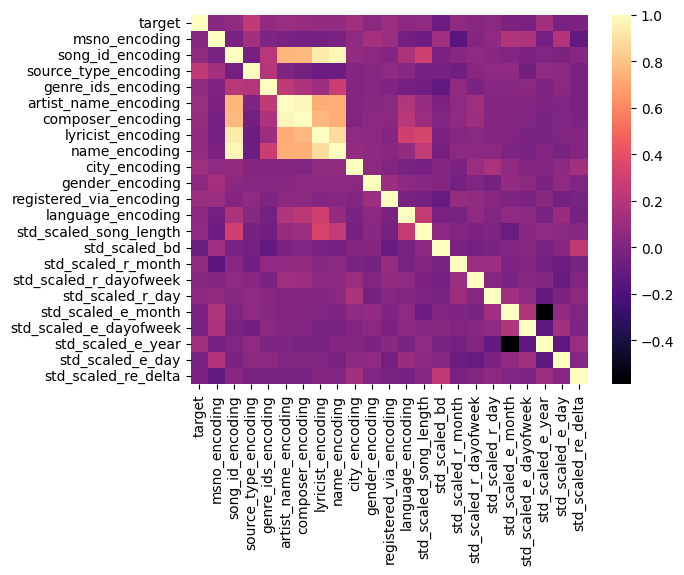

In [40]:
sns.heatmap(df_prepared.corr(), cmap='magma')

In [41]:
# Split into training and test datasets

x = df_prepared.drop(['target'], axis=1)
y = df_prepared['target']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

In [42]:
# Using the optuna library, we will select the optimal hyperparameters for several models: LGBMClassifier,
# RandomForestClassifier and XGBClassifier
seed = 42
np.random.seed(seed)

def objective(trial,data=x,target=y):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42)
    param = { 'random_state': 42,
              'n_jobs': 5,
              "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
              "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
              "max_depth": trial.suggest_int("max_depth", 1, 1000),
              "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
              "min_samples_leaf": trial.suggest_int("min_samples_split", 1, 20),
              "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy'])
    }
    model = RandomForestClassifier(**param)

    model.fit(train_x,train_y)

    preds = model.predict_proba(test_x)[:, 1]

    roc_auc = roc_auc_score(test_y, preds)

    return roc_auc

In [43]:
import optuna

# Define the seed value
SEED = 42  # You can use any integer value as the seed

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=100, timeout=600)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-10-04 09:59:52,289] A new study created in memory with name: no-name-182f466b-3eae-4470-babb-fca978ac2b25
[I 2023-10-04 09:59:53,289] Trial 0 finished with value: 0.5974332995609591 and parameters: {'n_estimators': 437, 'max_features': 'sqrt', 'max_depth': 157, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5974332995609591.
[I 2023-10-04 09:59:54,799] Trial 1 finished with value: 0.5825734549138806 and parameters: {'n_estimators': 641, 'max_features': None, 'max_depth': 833, 'min_samples_split': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5974332995609591.
[I 2023-10-04 09:59:55,557] Trial 2 finished with value: 0.5928740290442419 and parameters: {'n_estimators': 374, 'max_features': 'sqrt', 'max_depth': 612, 'min_samples_split': 4, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5974332995609591.
[I 2023-10-04 09:59:56,602] Trial 3 finished with value: 0.6197230665315772 and parameters: {'n_estimators': 510, 'max_features':

Number of finished trials: 100
Best trial: {'n_estimators': 957, 'max_features': None, 'max_depth': 726, 'min_samples_split': 2, 'criterion': 'gini'}


In [44]:
def objective(trial,data=x,target=y):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42)
    param = {
             'metric': 'roc_auc',
             'random_state': 42,
             'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
             'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1e2),
             'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 1e2),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.6,0.8,1.0]),
             'subsample': trial.suggest_categorical('subsample', [0.6,0.8,1.0]),
             'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.005,0.01,0.001,0.05]),
             'max_depth': trial.suggest_categorical('max_depth', [10,20, 50, 100]),
             'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
             'min_child_samples': trial.suggest_int('min_child_samples', 1, 300)
    }
    model = LGBMClassifier(**param)

    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],verbose=1)

    preds = model.predict_proba(test_x)[:, 1]

    roc_auc = roc_auc_score(test_y, preds)

    return roc_auc

In [45]:
import optuna
from lightgbm import LGBMClassifier

def objective(trial, data, target):
    # Define hyperparameters to optimize
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100)
    }

    # Create and train the model
    model = LGBMClassifier(**param)
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

    preds = model.predict_proba(test_x)[:, 1]

    # Calculate a metric for optimization (e.g., AUC)
    auc = roc_auc_score(test_y, preds)

    return auc

In [46]:
def objective(trial,data=x,target=y):

    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42)
    param = {
             'random_state': 42,
             'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
             'gamma': trial.suggest_int('gamma', 1, 1000),
             'subsample': trial.suggest_categorical('subsample', [0.4, 0.6, 0.8, 1.0]),
             'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.6, 0.8, 1.0]),
             'max_depth': trial.suggest_categorical('max_depth', [10, 20, 50, 100]),
             'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
             'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.05, 0.025, 0.001]),
             'tree_method': 'gpu_hist',
             'gpu_id': 0

    }
    model = XGBClassifier(**param)

    model.fit(train_x,train_y)

    preds = model.predict_proba(test_x)[:, 1]

    roc_auc = roc_auc_score(test_y, preds)

    return roc_auc

In [47]:
import optuna
import xgboost as xgb

def objective(trial, data, target):
    # Define hyperparameters to optimize
    param = {
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'gpu_id': -1  # Use CPU (no GPU)
    }

    # Create and train the model
    model = xgb.XGBClassifier(**param)
    model.fit(train_x, train_y)

    preds = model.predict_proba(test_x)[:, 1]

    # Calculate a metric for optimization (e.g., AUC)
    auc = roc_auc_score(test_y, preds)

    return auc

In [48]:
# Training models with optimal parameters

rf_clf = RandomForestClassifier(criterion='entropy', n_estimators=641, n_jobs=6, max_depth=833, min_samples_split=6)
XGB = XGBClassifier(colsample_bytree=1.0, gamma=1, gpu_id=0, learning_rate=0.01, max_depth=100,
                    min_child_weight=18, n_estimators=3373, subsample=0.8, tree_method='gpu_hist')
LGBM = LGBMClassifier(boosting_type='gbdt', n_estimators=837, min_child_samples=1, learning_rate=0.05,
                      reg_alpha=0.0254, reg_lambda=1.8398, colsample_bytree=0.8, subsample=0.8, max_depth=50, num_leaves=762)

In [52]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# Create a list of models
models = [LGBM, rf_clf, xgb.XGBClassifier(tree_method='exact')]

result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

# Train the models and record the results
for model in models:
    model_name = str(model).split("(")[0]  # Get the model name as a string
    train_model = model.fit(train_x, train_y)
    y_proba = train_model.predict_proba(test_x)[:, 1]
    y_pred = train_model.predict(test_x)

    accuracy = accuracy_score(test_y, y_pred)
    roc_auc = roc_auc_score(test_y, y_proba)
    print('Metrics values on the test sample:')
    print(f'Model {model_name}:\nROC_AUC - {round(roc_auc, 2)}\nAccuracy - {round(accuracy, 2)}\n{"-" * 40}')

    fpr, tpr, _ = roc_curve(test_y, y_proba)

    result_table = result_table.append({'classifiers': model_name,
                                        'fpr': fpr,
                                        'tpr': tpr,
                                        'auc': roc_auc}, ignore_index=True)

# Set the name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)


[LightGBM] [Info] Number of positive: 334, number of negative: 91
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 425, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.785882 -> initscore=1.300281
[LightGBM] [Info] Start training from score 1.300281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

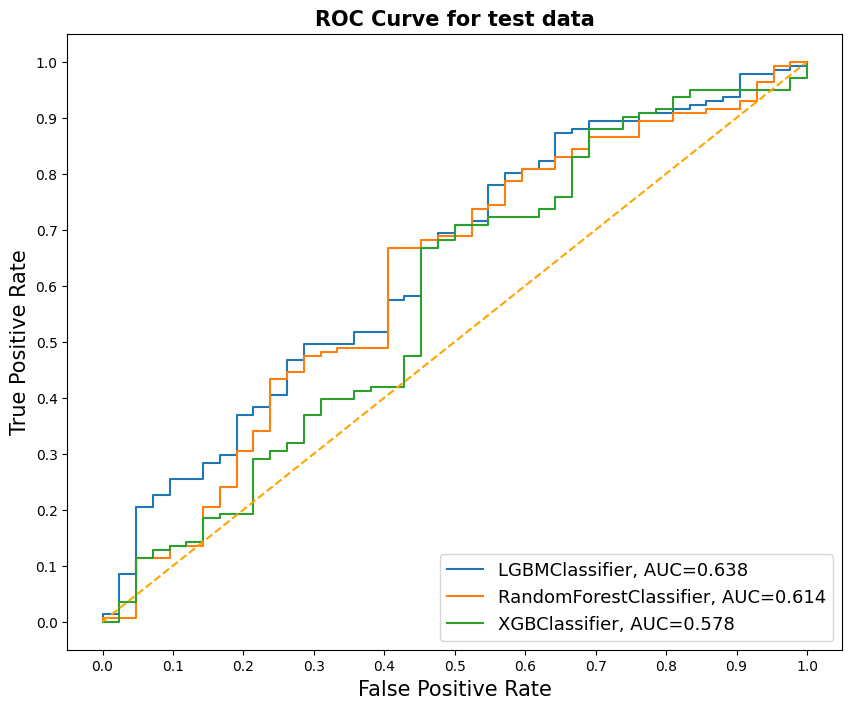

In [53]:
# Plotting ROC_AUC for models on test set

fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve for test data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show();

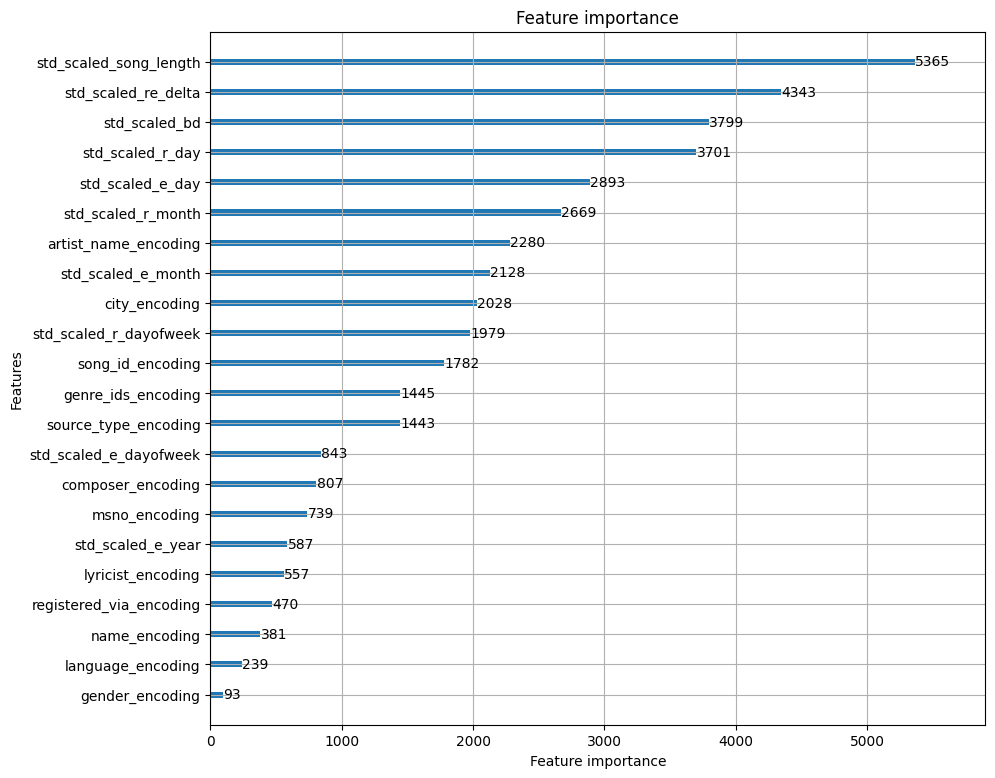

In [54]:
# feature_importances for a LGBMClassifier model

plot_importance(LGBM, figsize=(10, 9));

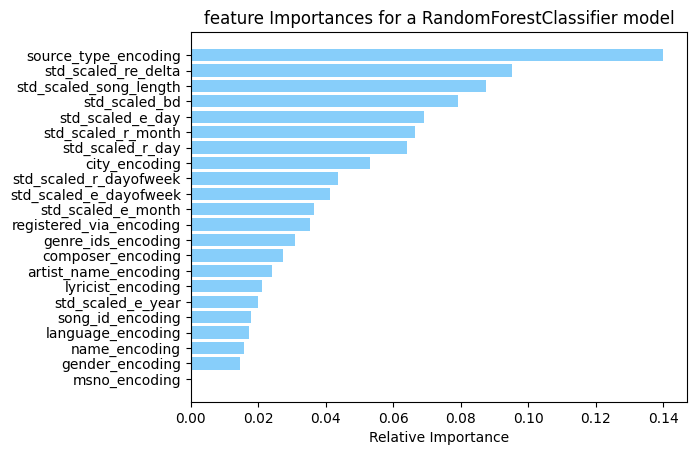

In [55]:
# feature_importances for a RandomForestClassifier model

feat_dict = dict(zip(rf_clf.feature_names_in_, rf_clf.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('feature Importances for a RandomForestClassifier model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show();

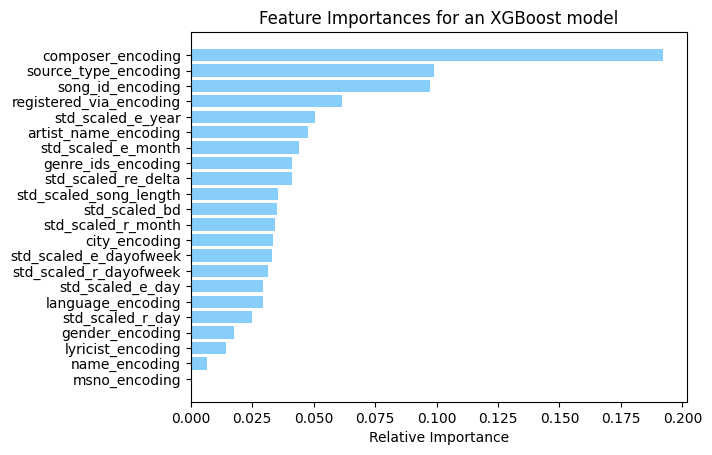

In [58]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Create and fit the XGBoost model
XGB = xgb.XGBClassifier(tree_method='exact')
XGB.fit(train_x, train_y)  # Fit the model on your training data

# Get the feature importances after the model has been fitted
feature_names = XGB.get_booster().feature_names
feat_dict = dict(zip(feature_names, XGB.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('Feature Importances for an XGBoost model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show()
